Copyright (c) 2022 Ziyang Jiang

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR 
PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE 
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, 
TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE 
OR OTHER DEALINGS IN THE SOFTWARE.

# Implicit Composite Kernel (ICK) for 1D Regression

Implicit Composite Kernel (ICK) is introduced to blend the strengths of deep learning and the clear modeling capabilities of GPs by using a composite kernel that combines a kernel implicitly defined by a neural network with a second kernel function chosen to model known properties (e.g., seasonality) based on Nystrom approximation and Cholesky decomposition.  ICK is flexible and can be used to include informative prior in neural networks in many fields of study involving high-dimensional data and multiple sources of information with perceptible trends, such as remote sensing, spatial statistics, or clinical diagnosis.

In this tutorial, we will show how to fit ICK on data containing both high-dimensional and low-dimensional modalities/information for a 1D regression task.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
sys.path.insert(0, '/work/zj63/ICK')
from sklearn.ensemble import RandomTreesEmbedding

from kernels.nystrom import ImplicitNystromKernel
from kernels.nn import ImplicitDenseNetKernel
from kernels.kernel_fn import *
from model.ick import ICK
from utils.trainer import Trainer
from utils.helpers import *

import torch
from torch import optim
from gpytorch.kernels import LinearKernel, SpectralMixtureKernel
from torch.distributions.multivariate_normal import MultivariateNormal

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

# Synthetic Data Generation

To begin with, we generate some synthetic data with 2 modalities $x$ and $t$. We adopt the GPytorch library to define a linear kernel (left figure) for $x$ and a spectral mixture kernel (middle figure) with 2 components for $t$. These 2 kernels are then multiplied together, resulting in a composite kernel (right figure). We also add a small number to the diagonal to make sure the kernel is positive definite (PD).

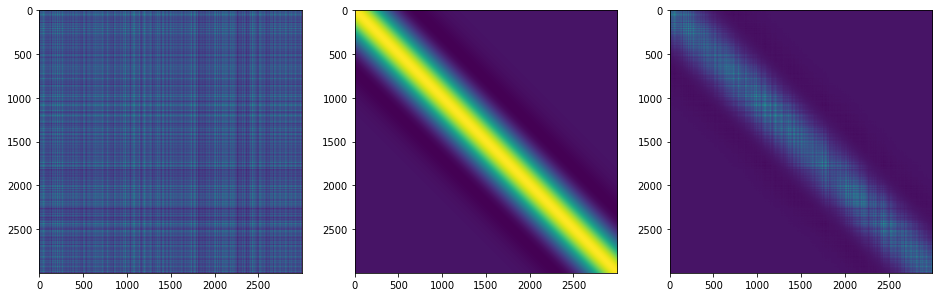

In [2]:
# Calculate the covariance matrix for linear kernel
fig, axs = plt.subplots(1,3,figsize=(16,7))
N = 3000
x = torch.rand(N,1)
cov_module = LinearKernel()
cov_lin = cov_module(x).evaluate().detach()
axs[0].imshow(cov_lin)
# Calculate the covariance matrix for spectral mixture kernel
t = torch.linspace(0,2,N).reshape(-1,1)
cov_module = SpectralMixtureKernel(num_mixtures=2)
cov_sm = cov_module(t).evaluate().detach()
axs[1].imshow(cov_sm)
cov = cov_lin*cov_sm + torch.eye(cov_lin.shape[0])*1e-3
axs[2].imshow(cov)

After defining the composite kernel, we take it as the covariance matrix of a multivariate Gaussian distribution and generate the targets $y$. In this way, $y$ is related to both $x$ and $t$ through a Gaussian Process (GP) with zero mean and covariance $K_{lin}(x,x')K_{sm}(t,t')$. In other words, $y \sim \mathcal{GP}(0, K_{lin}K_{sm})$. We also plot $x$ VS $y$ and $t$ VS $y$ as shown below.

Text(0, 0.5, 'y')

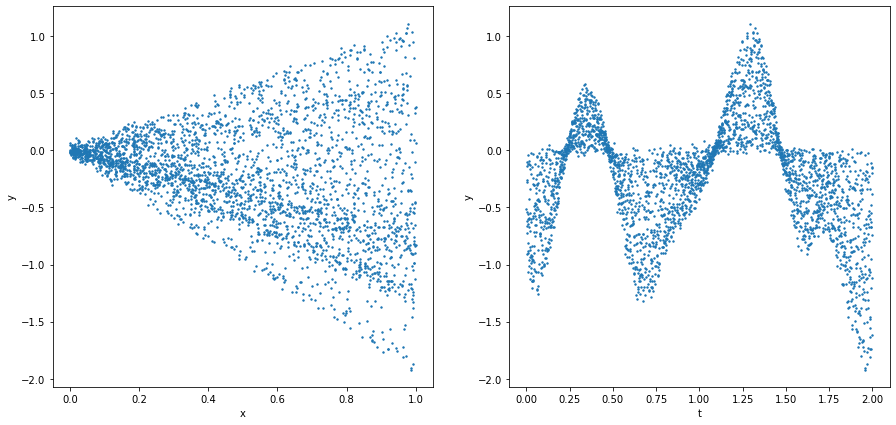

In [3]:
# Generate data points from GP with the multiplicative kernel
mv_normal_mul = MultivariateNormal(loc=torch.zeros(N),covariance_matrix=cov)
y = mv_normal_mul.sample()
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(torch.squeeze(x), y, s=2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].scatter(torch.squeeze(t), y, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')

We then use an unsupervised algorithm called Totally Random Trees to map $x$ into a sparse representation in a higher dimension, i.e. $x_{transformed}$. Our goal is to capture the relationship between the multimodal data $\{x_{transformed}, t\}$ and the target $y$.

In [4]:
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x_transformed = torch.tensor(rt_model.fit_transform(np.array(x).reshape(-1,1)).toarray())
data, target = [x_transformed.numpy(), t.numpy()], y.numpy()
x_train, y_train, x_val, y_val, x_test, y_test = train_val_test_split(data, target, shuffle_data=True, random_seed=2020)
data_generators = create_generators_from_data(x_train, y_train, x_val, y_val, x_test, y_test)

# Construct Implicit Kernels

To build the ICK model, we first need to determine which kernel we would like to assign to each modality in the data. Since $x_{transformed}$ is *made to be* high-dimensional, we use a single-hidden-layer dense neural network with a width of 64 to fit $x$. Next, we use a spectral-mixture kernel to fit $t$. **Note that the dimension of features in the latent space (i.e. ```latent_feature_dim```) must be equal in order to compute the inner product.** Also, when using Nystrom approximation as a kernel-to-latent-space mapping, it is highly recommended to set **the space of the low-rank matrix (i.e. ```nys_space```) to cover the entire input space (or one period for periodic kernels).** In our case, we set ```nys_space``` to be $0 \leq t \leq 2$.

In [5]:
# Specify kernels to x and t
kernel_nn = ImplicitDenseNetKernel(
    input_dim=40,
    latent_feature_dim=16,
    num_blocks=1,
    num_layers=1,
    num_units=64,
)
kernel_sm = ImplicitNystromKernel(
    kernel_func=spectral_mixture_kernel_1d_nys, 
    params=['weight','mean','cov','noise'],
    vals=[[0.8,0.2],[0.5,0.5], [2.,0.5], 0.1],
    trainable=[True,True,True,True],
    alpha=1e-5,
    num_inducing_points=16, 
    nys_space=[[0.,2.]]
)

# Training ICK

After passing the implicit kernels to the ICK model, we can now instantiate a trainer and fit ICK to the data as shown below.

In [ ]:
model = ICK(
    num_modalities=2,
    kernel_assignment=[kernel_nn,kernel_sm]
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.1)
epochs, patience = 300, 10
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optimizer=optimizer,
    model_save_dir="./model_checkpoints",
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()

# Visualization of Predictions

To see how ICK performs on this regression task, we evaluate it on the test data. Since the spectral mixture pattern in $t$ is more complex and harder to capture than the linear pattern in $x$, we plot both $t$ VS $y_{true}$ and $t$ VS $y_{pred}$ as displayed below. It can be observed that ICK captures the relationship between $t$ and $y$ relatively well. 

(-2.0, 1.5)

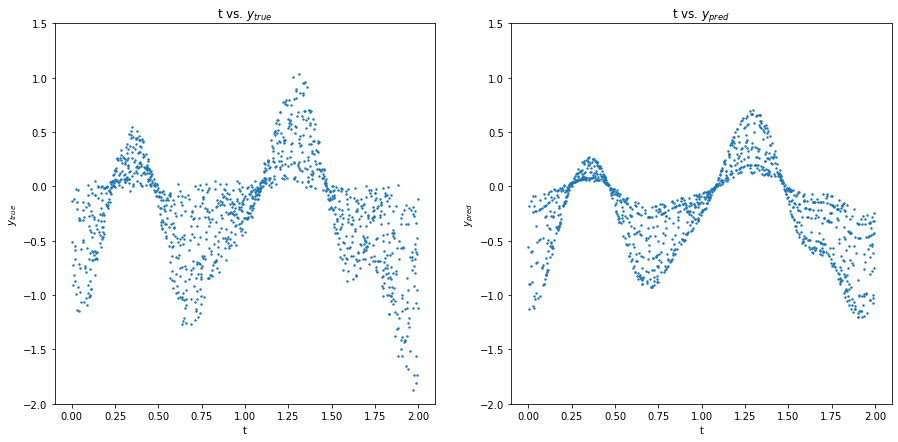

In [9]:
# Make predictions with ICKy
y_test_pred, y_test_true = trainer.predict()
t = np.squeeze(x_test[1])
fig, axs = plt.subplots(1,2,figsize=(15,7))
axs[0].scatter(t, y_test_true, s=2)
axs[0].set_xlabel('t')
axs[0].set_ylabel('$y_{true}$')
axs[0].set_title('t vs. $y_{true}$')
axs[0].set_ylim(-2, 1.5)
axs[1].scatter(t, y_test_pred, s=2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('$y_{pred}$')
axs[1].set_title('t vs. $y_{pred}$')
axs[1].set_ylim(-2, 1.5)